In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import FlexibleDiscriminator, FlexibleGenerator
from pretrain_methods import CustomImageDataset, shuffle_image, unshuffle_image, get_perms
import itertools
import random


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [3]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

image_size = 64
num_pieces = 9

discriminator_path = './output/models/d_j9.pth'
generator_path = './output/models/g_j9.pth'

generator = FlexibleGenerator(output_size=image_size)
state_dict_gen = torch.load(generator_path, map_location=torch.device(device))
generator.load_state_dict(state_dict_gen)

discriminator = FlexibleDiscriminator(input_size=image_size)
state_dict_disc = torch.load(discriminator_path, map_location=torch.device(device))
discriminator.load_state_dict(state_dict_disc)

<All keys matched successfully>

torch.Size([16, 3, 64, 64])


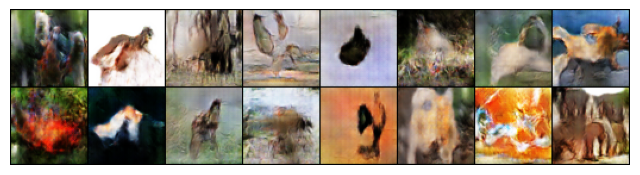

In [21]:
latent_dim = 100
# torch.manual_seed(seed)

with torch.no_grad():
    fake_samples = generator(torch.randn(16, latent_dim, 1, 1).to('cpu')).to('cpu')  # Generate on GPU, move to CPU for visualization
    print(fake_samples.shape)
    fake_grid = torchvision.utils.make_grid(fake_samples, padding=1, normalize=True)
    fig1 = plt.figure(figsize=(8, 12))
    ax1 = fig1.subplots()
    ax1.imshow(np.transpose(fake_grid, (1, 2, 0)))
    ax1.axis('off')
    # ax1.set_title('Generated images')
    plt.show()

In [5]:
# Define your transforms for RGB images.
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Mean and std for RGB channels
])
data_path = 'data/pre-training/animals-10/test'
# Instantiate your custom dataset with the updated transform
custom_dataset = CustomImageDataset(directory=data_path, transform=transform)

In [8]:
all_permuations = list(itertools.permutations(range(num_pieces)))
if num_pieces:
    selected_perms = get_perms(num_pieces, num_permutations=30, seed=seed, printer=True)
else:
    selected_perms = None

1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30


In [9]:
print(selected_perms)
print(list(itertools.permutations(range(4))))

[(8, 2, 4, 5, 6, 1, 7, 3, 0), (0, 1, 2, 3, 4, 5, 6, 7, 8), (1, 0, 3, 2, 5, 4, 8, 6, 7), (2, 3, 0, 1, 7, 6, 4, 8, 5), (3, 4, 1, 0, 8, 7, 2, 5, 6), (4, 5, 6, 7, 0, 8, 1, 2, 3), (5, 6, 7, 8, 1, 0, 3, 4, 2), (6, 7, 8, 4, 2, 3, 5, 0, 1), (7, 8, 5, 6, 3, 2, 0, 1, 4), (0, 1, 2, 3, 4, 5, 6, 8, 7), (1, 0, 3, 2, 5, 4, 7, 6, 8), (2, 3, 0, 1, 6, 7, 8, 4, 5), (3, 2, 1, 0, 7, 8, 4, 5, 6), (4, 5, 6, 7, 8, 0, 1, 2, 3), (5, 4, 7, 8, 0, 6, 2, 3, 1), (6, 7, 8, 4, 1, 3, 5, 0, 2), (8, 6, 4, 5, 2, 1, 3, 7, 0), (0, 8, 5, 6, 3, 2, 7, 1, 4), (7, 1, 2, 3, 4, 5, 0, 6, 8), (1, 0, 3, 2, 5, 4, 6, 8, 7), (2, 3, 0, 1, 6, 7, 8, 5, 4), (3, 2, 1, 0, 7, 8, 5, 4, 6), (4, 5, 6, 7, 8, 0, 1, 3, 2), (5, 4, 7, 8, 0, 6, 2, 1, 3), (6, 7, 8, 4, 1, 2, 3, 0, 5), (7, 8, 5, 6, 3, 1, 4, 2, 0), (8, 6, 4, 5, 2, 3, 0, 7, 1), (0, 1, 2, 3, 4, 5, 7, 6, 8), (1, 0, 3, 2, 5, 4, 8, 7, 6), (2, 3, 0, 1, 6, 7, 4, 8, 5)]
[(0, 1, 2, 3), (0, 1, 3, 2), (0, 2, 1, 3), (0, 2, 3, 1), (0, 3, 1, 2), (0, 3, 2, 1), (1, 0, 2, 3), (1, 0, 3, 2), (1, 2, 0, 3), (1

tensor([28])


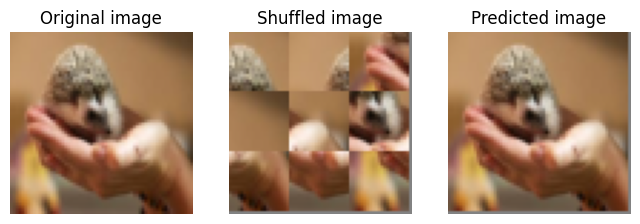

In [27]:
# real_images = torch.stack((custom_dataset[62], custom_dataset[17]), dim=0) #<-- Use for 2 images
real_images = custom_dataset[62].unsqueeze(0)
shuffled_images, real_ids = shuffle_image(real_images, num_pieces, selected_perms) #<-- Use for 1 image
# reconstructed_images = unshuffle_image(shuffled_images, real_ids, num_pieces, selected_perms)

_, pred_jig = discriminator(shuffled_images)
pred_ids = torch.argmax(pred_jig, dim=1)
print(pred_ids)
predicted_images = unshuffle_image(shuffled_images, pred_ids, num_pieces, selected_perms)

grid_og = torchvision.utils.make_grid(real_images, padding=0, normalize=True)
grid_jig = torchvision.utils.make_grid(shuffled_images, padding=0, normalize=True)
# grid_recon = torchvision.utils.make_grid(reconstructed_images, padding=0, normalize=True)
grid_pred = torchvision.utils.make_grid(predicted_images, padding=0, normalize=True)

fig = plt.figure(figsize=(8, 12))
# ax = fig.subplots(nrows=3) #<-- Use for 2 images
ax = fig.subplots(ncols=3) #<-- Use for 1 image
ax[0].imshow(np.transpose(grid_og, (1, 2, 0)))
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(np.transpose(grid_jig, (1, 2, 0)))
ax[1].axis('off')
ax[1].set_title('Shuffled image')
ax[2].imshow(np.transpose(grid_pred, (1, 2, 0)))
ax[2].axis('off')
ax[2].set_title('Predicted image')

plt.show()


In [11]:
import torch
import torch.nn as nn
import torchmetrics as TM
import torchvision.transforms as T

from finetune_methods import (
    IoUMetric,
    TrimapClasses,
    OxfordIIITPetsAugmented,
    args_to_dict,
    tensor_trimap,
    # print_test_dataset_masks,
)
from models import FlexibleGANForSegmentation

In [12]:
# def prediction_accuracy(ground_truth_labels, predicted_labels):
#     eq = ground_truth_labels == predicted_labels
#     return eq.sum().item() / predicted_labels.numel()
    
# def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
#     to_device(model.eval())
#     predictions = model(to_device(test_pets_targets))
#     test_pets_labels = to_device(test_pets_labels)
#     # print("Predictions Shape: {}".format(predictions.shape))
#     pred = nn.Softmax(dim=1)(predictions)

#     pred_labels = pred.argmax(dim=1)
#     # Add a value 1 dimension at dim=1
#     pred_labels = pred_labels.unsqueeze(1)
#     # print("pred_labels.shape: {}".format(pred_labels.shape))
#     pred_mask = pred_labels.to(torch.float)
    
#     # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
#     iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
#     iou_accuracy = iou(pred_mask, test_pets_labels)
#     pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
#     pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
#     custom_iou = IoUMetric(pred, test_pets_labels)
#     title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
#     print(title)
#     # print(f"Accuracy: {accuracy:.4f}")

#     # Close all previously open figures.
#     close_figures()
    
#     fig = plt.figure(figsize=(10, 12))
#     fig.suptitle(title, fontsize=12)

#     fig.add_subplot(3, 1, 1)
#     plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
#     plt.axis('off')
#     plt.title("Targets")

#     fig.add_subplot(3, 1, 2)
#     plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
#     plt.axis('off')
#     plt.title("Ground Truth Labels")

#     fig.add_subplot(3, 1, 3)
#     plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
#     plt.axis('off')
#     plt.title("Predicted Labels")
    
#     # if save_path is not None:
#     #     plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
#     # end if
    
#     if show_plot is False:
#         close_figures()
#     else:
#         plt.show()
#     # end if
# # end def

In [13]:
model_filepath = './output/models/ft_j9_100p.pth'
data_folder = './data/fine-tuning'

model = FlexibleGANForSegmentation()
model.load_state_dict(torch.load(model_filepath, map_location=torch.device('cpu')))

transform_dict = args_to_dict(
        pre_transform=T.ToTensor(),
        pre_target_transform=T.ToTensor(),
        common_transform=T.Compose([T.Resize((image_size, image_size), interpolation=T.InterpolationMode.NEAREST),]),
        post_target_transform=T.Compose([T.Lambda(tensor_trimap),]),
        )

pets_test = OxfordIIITPetsAugmented(
        root=data_folder,
        split="test",
        target_types="segmentation",
        download=False,
        **transform_dict,
        )

pets_test_loader = torch.utils.data.DataLoader(
        pets_test,
        batch_size=4,
        shuffle=True,
)

In [14]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    t2img = T.ToPILImage()
    model.eval()
    predictions = model(test_pets_targets)
    test_pets_labels = test_pets_labels
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)
    
    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND)
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = TM.classification.MulticlassAccuracy(3, average='micro')
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    plt.show()


Epoch: 20, Accuracy[Pixel: 0.8525, IoU: 0.6394


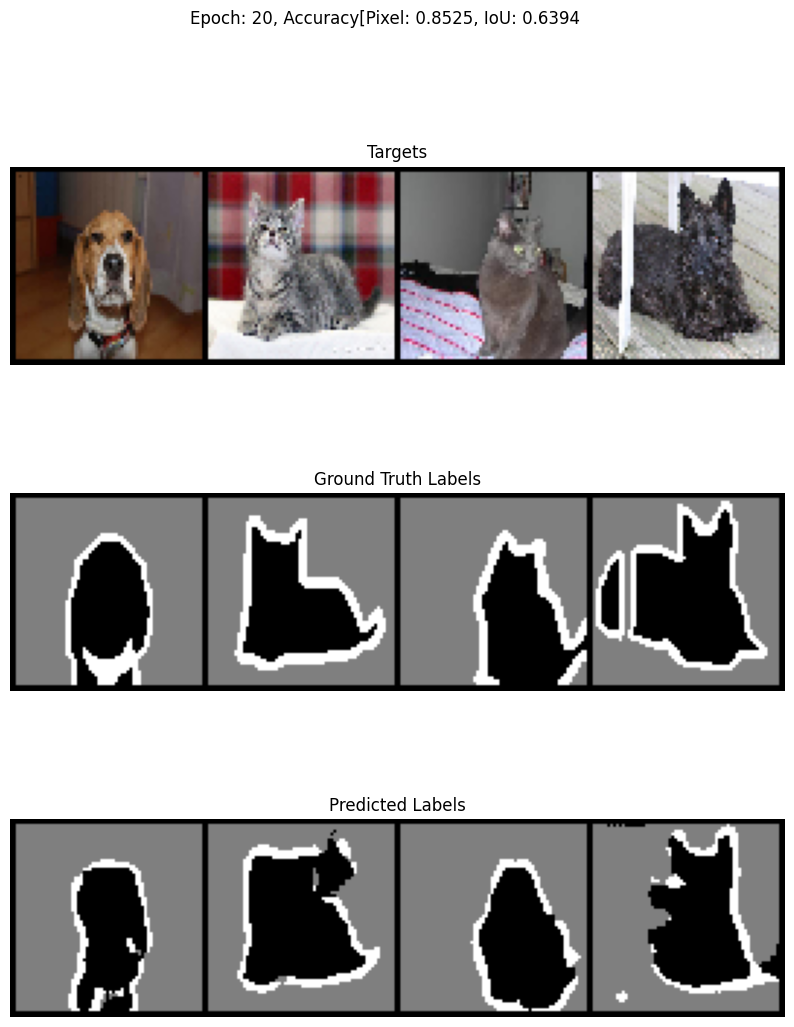

In [15]:
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))

print_test_dataset_masks(model, test_pets_inputs, test_pets_targets, 20, show_plot=True, save_path=False)